Misurazioni di CO2
- https://gml.noaa.gov/aftp/data/trace_gases/co2/pfp/surface/co2_surface-pfp_1_ccgg_ASCIItext.zip
- https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv

crescita della popolazione
https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/EXCEL_FILES/1_General/WPP2022_GEN_F01_DEMOGRAPHIC_INDICATORS_COMPACT_REV1.xlsx

deforestazione
- https://ourworldindata.org/deforestation
- blob:https://ourworldindata.org/dd888c14-a03c-4337-8bce-80b500645beb
- blob:https://ourworldindata.org/93fbc00d-961c-48e5-aead-5e66b944adb8
- blob:https://ourworldindata.org/7606fe55-a2bf-4756-a1b4-2d0743bdbf74

STUDIO DI CORRELAZIONE TRA LA DEFORESTAZIONE LA CO2 E LA CRESCITA DELLA POPOLAZIONE

In [ ]:
# importiamo le librerie necessarie per il nostro studio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# configuriamo le impostazioni di visualizzazione
sns.set_style('whitegrid')
sns.set_palette('Set2')

# importiamo le librerie di sistema
import os
import sys
import csv



In [ ]:
# creiamo il percorso di path 
path = sys.path[0] + '/'

# muoviamoci indietro di una cartella
dataset_path = os.path.abspath(os.path.join(path, os.pardir))

# creiamo il percorso della cartella di lavoro dei dataset
work_dir = dataset_path + '/dataset/defores/'


print(work_dir)
print(path)

COMINCIAMO CON CREARE UN UNICO DATASET CON LA MEDIA DEI VALORI DI CO2 DELLE VARIE STAZIONI DI MISURAZIONE
DIVISE PER ANNO

In [ ]:
# crea una lista di file nella cartella di lavoro dei dataset
file_list = os.listdir(work_dir + 'txt/')
print(file_list)

# Creiamo una funzione per convertire i file txt in csv andando a prendere i dati a partire dalla riga dove 
# cominciano i dati veri e propri
def convert_txt_to_csv(file_name):
    # leggiamo il file txt
    with open(work_dir + 'txt/' + file_name, 'r') as in_file:
        stripped = (line.strip() for line in in_file)
        lines = (line.split(",") for line in stripped if line)

        # creiamo una lista delle righe
        file = []
        for line in lines:
            file.append(line)
        
        # nella prima riga di ogni file txt è presente il numero della righe di heater
        header = int(file[0][0].split()[-1])

        # creiamo il file csv a partire dalla riga header -1 perchè la numerazione delle righe parte da 0
        with open(work_dir + 'csv/' + file_name.replace('.txt', '.csv'), 'w') as out_file:
            writer = csv.writer(out_file)
            writer.writerows(file[header-1:])

# convertiamo tutti i file txt in csv
for i in file_list:
    convert_txt_to_csv(i)

# creiamo una lista dei file csv
csv_list = os.listdir(work_dir + 'csv/')

# creiamo una funzione per creare un dataframe con i dati di tutti i dataset
def create_df(file_list):
    # creiamo l'oggetto dataframe
    df = pd.DataFrame()

    # creiamo un ciclo for per leggere tutti i file csv e creare un dataframe con i dati
    for i in file_list:
        df_temp = pd.read_csv(work_dir + 'csv/' + i, sep=' ')
        # creiamo una colonna con il nome del dataset in modo poi da poterlo usare come chiave per il nome della colonna
        name_data = df_temp['site_code'].unique()[0]
        # ora estraiamo solo le colonne che ci interessano e cambiamo il nome della colonna value con il nome del dataset
        df_temp = df_temp[['year', 'value']].copy()
        df_temp = df_temp.rename(columns={'value': name_data})
        # raggruppiamo per anno e calcoliamo la media dei valori
        df_temp = df_temp.groupby('year').mean()
        # uniamo i dataframe
        df = pd.concat([df, df_temp], axis=1)
        # rinominiamo la colonna con la media dei valori
        df['CO2'] = df.mean(axis=1)
        # ordina le righe in ordine numerico crescente 
        df = df.sort_index()

    return df['CO2']

df = create_df(csv_list)
df.to_csv(work_dir + '/CO2.csv')

In [ ]:
df1 = pd.read_csv(work_dir + '/co2_mm_mlo.csv')
df1 = df1[['year', 'average']]
df1.rename(columns={'average': 'CO2'}, inplace=True)
df1 = df1.groupby('year').mean()
df1.to_csv(work_dir + '/CO2_1.csv')


ORA ANALIZIAMO IL DATASET DELL'ANDAMENTO DELLA CRESCITA DELLA POPOLAZIONE

In [ ]:
# creiamo una lista di file nella cartella di lavoro dei dataset
dataset_list = os.listdir(work_dir)

In [ ]:
pop_list = []
for i in dataset_list:
    #print(i)
    if 'WPP' in i: 
        pop_list.append(i)

df = pd.read_csv(work_dir + pop_list[0], encoding='latin-1')

# estraiamo l'elenco delle colonne che ci interessano
col = [
    'Year',
    'Total Population, as of 1 July (thousands)', 
    'Population Density, as of 1 July (persons per square km)'    
    ]

# creiamo un dataframe con i dati che ci interessano
df = df[col].copy()

# rinominiamo le colonne
df.rename(columns={
    'Year': 'year', 
    'Total Population, as of 1 July (thousands)': 'pop', 
    'Population Density, as of 1 July (persons per square km)': 'pop_density'}, 
    inplace=True)

# creiamo la colonna della superficie occupata dalla popolazione

# convertiamo la colonna pop e pop_density in float
df['pop'] = df['pop'].str.replace(' ', '').astype(float)
df['pop_density'] = df['pop_density'].str.replace(',', '.').astype(float)
df['pop_area'] = round(df['pop'] / df['pop_density'], 2)

df.to_csv(work_dir + '/pop.csv')


ORA ANALIZZIAMO I DATASET DELLA DEFORESTAZIONE

In [ ]:
forset_list = []
for i in dataset_list:
    #print(i)
    if 'area' in i: 
        forset_list.append(i)

In [ ]:
# analiziamo il secondo dataset che contiene i dati della foresta
df2 = pd.read_csv(work_dir + '/' + forset_list[1], encoding='latin-1')
df2 = df2[df2['Entity'] == 'World']
df2.drop(columns=['Code', 'Entity'], inplace=True)
df2.rename(columns={'Year': 'year', 'Forest cover': 'forest_area_%'}, inplace=True)
df2.to_csv(work_dir + '/forest_area.csv')
print(df2.head())

ORA UNIAMO I DATASET DELLA CRESCITA DELLA POPOLAZIONE E DELLA DEFORESTAZIONE E DELLA co2 E CERCHIAMO DI TROVARE UNA CORRELAZIONE

In [ ]:
df1 = pd.read_csv(work_dir + '/CO2_1.csv').set_index('year')
df1

In [ ]:
# creiamo un dataframe con i dati che ci interessano
#df1 = pd.read_csv(work_dir + '/CO2.csv').set_index('year')
df1 = pd.read_csv(work_dir + '/CO2_1.csv').set_index('year')
df2 = pd.read_csv(work_dir + '/pop.csv').drop(columns=['Unnamed: 0']).set_index('year')
df3 = pd.read_csv(work_dir + '/forest_area.csv').drop(columns=['Unnamed: 0']).set_index('year')

# uniamo i dataframe
df = pd.concat([df1, df2, df3], axis=1).sort_index()
df.drop(columns=['pop_density', 'pop_area'], inplace=True)

# eliminiamo l'ultima riga che contiene i dati del 2021
df = df[:-3]

df.to_csv(work_dir + '/CO2_pop_forest.csv')

In [ ]:
# calcoliamo la correlazione tra le varie colonne
corr = df.corr()

# creiamo una heatmap per visualizzare la correlazione
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()


In [ ]:
# visualiziamo su un grafico con assi separati i dati relativi alla CO2 e alla popolazione e alla deforestazione
fig, ax1 = plt.subplots(figsize=(15, 10))
ax2 = ax1.twinx()
ax3 = ax1.twinx()

ax1.plot(df.index, df['CO2'], color='red', label='CO2')
ax2.plot(df.index, df['pop'], color='blue', label='pop')
ax3.plot(df.index, df['forest_area_%'], color='green', label='forest_area_%')

ax1.set_xlabel('year')
ax1.set_ylabel('CO2', color='red')
ax2.set_ylabel('pop', color='blue')
ax3.set_ylabel('forest_area_%', color='green')

plt.show()

In [ ]:
# vediamo le pairplot tra le varie colonne
sns.pairplot(df)
plt.show()

In [ ]:
print(df.tail())

In [ ]:
# facciamo una regressione lineare multipla per calcolare il valore della CO2 in base alla popolazione e alla deforestazione
from sklearn.linear_model import LinearRegression

# creiamo un oggetto LinearRegression
lr = LinearRegression()

# eliminiamo le righe con valori nulli
df.dropna(inplace=True)

# creiamo le variabili indipendenti e dipendenti
X = df[['pop', 'forest_area_%']]
y = df['CO2']

# scaliamo i dati
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.values.reshape(-1, 1))

# suddividiamo il dataset in train e test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# addestriamo il modello
lr.fit(X_train, y_train)

# facciamo le previsioni
y_pred = lr.predict(X_test)

# valutiamo il modello
from sklearn.metrics import mean_squared_error, r2_score

print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))




 - Calcolare l'andamento della riduzione di foreste con una regressione polinomiale
 - aggiungere i dati mancanti della deforestazione al dataset della deforestazione 
 - rimettere in grafico la deforestazione con i dati mancanti aggiunti

CALCOLIAMO CON UNA REGRESSIONE POLINOMIALE L'ANDAMENTO LA DIMINUZIONE DELLA FORESTAZIONE

In [ ]:
# carichiamo il dataset della forestazione
df_forests = pd.read_csv(work_dir + '/forest_area.csv').drop(columns=['Unnamed: 0'])

In [ ]:
# carichiamo ora le librerie per la regressione lineare lineare e polinomiale, le metriche e la divisione del dataset
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# cominciamo a creare le variabili indipendenti e dipendenti
X = df_forests['year'].values.reshape(-1, 1)
y = df_forests['forest_area_%'].values.reshape(-1, 1)

# dividiamo il dataset in train e test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2, random_state=42)

# facciamo le previsione con il modello per gli anni tra il 1950 e il 1990
x_pre = np.arange(1950, 1990).reshape(-1, 1)


In [ ]:
# valutiamo una regressione lineare
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# calcoliamo le metriche
mse_lr = mean_squared_error(y_test, y_pred)
r2_lr = r2_score(y_test, y_pred)

# valutiamo la regressione lineare
print('Mean squared error: %.2f' % mse_lr)
print('Coefficient of determination: %.2f' % r2_lr)

# creiamo un dataframe con i valori predetti e quelli reali
df = pd.DataFrame({'Predicted': y.flatten()}, index=X.flatten())

# sommiamo i valori predetti al dataframe
y_pred_pre = lr.predict(x_pre)
df_lr_pre = pd.DataFrame({'Predicted': y_pred_pre.flatten()}, index=x_pre.flatten())

# concateniamo i due dataframe
df_lr = pd.concat([df, df_lr_pre])

# visualizziamo i dati
plt.figure(figsize=(15, 10))
plt.scatter(df_lr.index, df_lr['Predicted'], color='red', label='Actual')
plt.legend()
plt.show()

In [ ]:
# usiamo numpy per creare un array con i valori predetti
# https://runebook.dev/it/docs/numpy/reference/generated/numpy.polyfit

import warnings

x = np.arange(1950, 1990).reshape(-1, 1)

error_list = [] 
for i in range(1, 4):
    z = np.polyfit(X.flatten(), y.flatten(), i)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', np.RankWarning)
        p30 = np.poly1d(z)
        y_poly = p30(X)

        # calcoliamo le metriche
        mse = mean_squared_error(y, y_poly)
        r2 = r2_score(y, y_poly)

        # aggiungiamo i valori delle metriche alla lista
        error_list.append([i, mse, r2])

        # stampiamo le metriche
        print('Order: ' + str(i))
        print('Mean squared error: %.2f' % mse)
        print('Coefficient of determination: ', r2)

        plt.plot(X, y, '.', X, y_poly, '-', label='Order ' + str(i))
        plt.legend()
        plt.show()

# calcoliamo il miglior valore di r2 e il suo indice nella lista
r2_list = [i[2] for i in error_list]
r2_max = max(r2_list)
r2_max_index = r2_list.index(r2_max)

# stampiamo il valore di r2 e l'ordine del polinomio
best_r2 = r2_max
best_degree = error_list[r2_max_index][0]

print('Best r2: ', best_r2)
print('Best degree: ', best_degree)

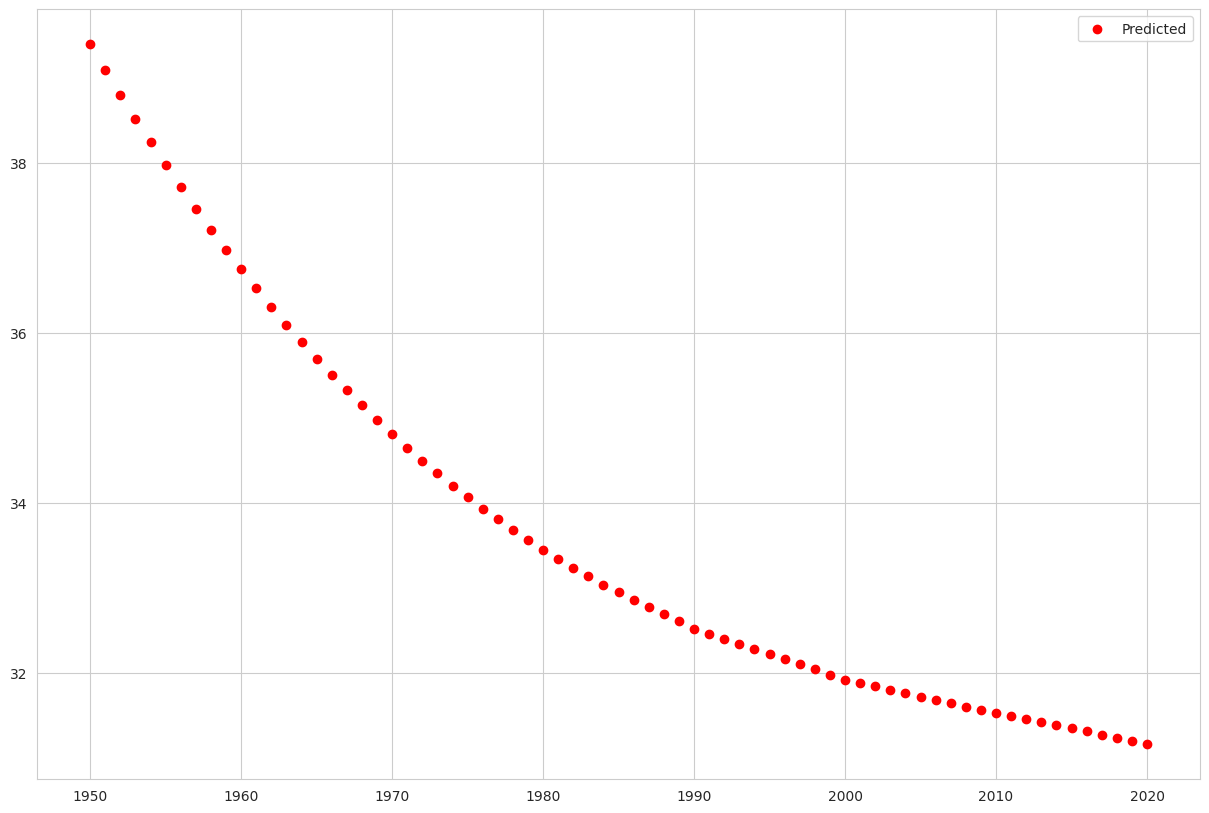

In [66]:
z_pred = np.polyfit(X.flatten(), y.flatten(), best_degree)
p30_pred = np.poly1d(z_pred)
y_poly_pred = p30_pred(x_pre)

# creiamo un dataframe con i valori predetti e quelli reali
df = pd.DataFrame({'year': X.flatten(), 'Predicted': y.flatten()})
df_poly_pre = pd.DataFrame({'year': x_pre.flatten(), 'Predicted': y_poly_pred.flatten()})
df_poly = pd.concat([df, df_poly_pre])

# visualizziamo i dati
plt.figure(figsize=(15, 10))
plt.scatter(df_poly['year'], df_poly['Predicted'], color='red', label='Predicted')
plt.legend()
plt.show()

In [67]:
# ordiniamo il dataframe in base all'anno
df_poly = df_poly.sort_values(by='year')
# ricreiamo l'indice
df_poly.reset_index(drop=True, inplace=True)
df_poly.to_csv(work_dir + '/forest_area_poly.csv')